In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *

import meteo                    # wind_dir_speed
import metpy.calc as mpcalc
from metpy.units import units
import lcl

from windrose import WindroseAxes
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background

from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d, perc_distribution_pvalue
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy')

In [5]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.

In [21]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)

In [7]:
# load U component
U_day = xr.open_dataset(wrf_files[files_ls.index('U.nc')])
U_day = U_day['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000')).groupby('time_counter.day').mean()

i = np.arange(0, sea_mask.shape[1])
U_day = 0.5*(U_day[:,:,:,i] + U_day[:,:,:,i+1])

In [8]:
# select data oversea
U_day = U_day.where(sea_mask, drop=False)

In [11]:
U_day = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/U/U_day_feb.npy')

In [12]:
my_save_data('/venus/tesi_ale/data_EU/WIND/daily/FEB/U/U_day_feb.npy', [U_day])

In [13]:
## U DISTRIBUTION
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_U, pstd_U, pstderr_U, pnpoints_U, ppvalue_U_sub = \
dist_3d_subsample(dsst_day, U_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [9]:
# load V component
V_day = xr.open_dataset(wrf_files[files_ls.index('V.nc')])
V_day = V_day['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000')).groupby('time_counter.day').mean()

j = np.arange(0, sea_mask.shape[0])
V_day = 0.5*(V_day[:,:,j,:] + V_day[:,:,j+1,:])

In [12]:
# select data oversea
V_day = V_day.where(sea_mask, drop=False)

NameError: name 'V_day' is not defined

In [10]:
V_day = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/V/V_day_feb.npy')

In [13]:
my_save_data('/venus/tesi_ale/data_EU/WIND/daily/FEB/V/V_day_feb.npy', [V_day])

In [16]:
## V DISTRIBVTION
perc_step = 5
nbins = int(100/perc_step) # NVmber of bins.

pdist_dsst, pdist_V, pstd_V, pstderr_V, pnpoints_V, ppvalVe_V_sub = \
dist_3d_subsample(dsst_day, V_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [6]:
# reading temperature
pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
pot_temp = pot_temp['T']
pot_temp = pot_temp.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
pot_temp = pot_temp.where(sea_mask, drop=False)
pot_temp = pot_temp.groupby('time_counter.day').mean()

T0 = 300. 

pot_temp_full = pot_temp+T0

In [11]:
## TEMPERATURE DISTRIBUTION
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_theta, pstd_theta, pstderr_theta, pnpoints_theta, ppvalue_theta_sub = \
dist_3d_subsample(dsst_day, pot_temp_full.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [7]:
# reading geopotential height
GPH_base = xr.open_dataset(wrf_files[files_ls.index('PHB.nc')])
GPH_base = GPH_base['PHB']/9.81

GPH = xr.open_dataset(wrf_files[files_ls.index('PH.nc')])
GPH = GPH.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
GPH = GPH['PH']/9.81

GPH = GPH_base + GPH
GPH = GPH.transpose('time_counter', 'lev_W', 'y_grid_M', 'x_grid_M')
GPH = GPH.where(sea_mask, drop=False)

GPH = GPH.groupby('time_counter.day').mean()

#GPH_base = GPH_base.where(sea_mask, drop=False)
del GPH_base

In [8]:
# vertical interpolation of geopotential
GPH_inter = np.zeros_like(pot_temp)
for i in range(39):
    GPH_inter[:,i,:,:] = (GPH[:,i+1,:,:]+GPH[:,i,:,:])*0.5

In [27]:
## GPH DISTRIBVTION
perc_step = 5
nbins = int(100/perc_step) # NVmber of bins.

pdist_dsst, pdist_gph, pstd_gph, pstderr_gph, pnpoints_gph, ppvalue_gph_sub = \
dist_3d_subsample(dsst_day, GPH_inter, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [8]:
# mean GPH over domain
GPH_mean = GPH.mean(axis=(0,2,3))

In [9]:
my_save_data('/venus/tesi_ale/data_EU/GPH/daily/FEB/GPH_mean_column.npy', [GPH_mean])

In [34]:
# GPH_mean = np.load('/venus/tesi_ale/data_EU/GPH/daily/FEB/GPH_mean_column.npy')
mean_vert_pres = np.load('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy')

In [ ]:
Ri_feb_pdist = mpcalc.gradient_richardson_number(GPH*units.meters, pot_temp_full*units.kelvin, U_day*units('m/s'), V_day*units('m/s'), vertical_dim=0)


In [9]:
#### step by step calculation of Ri
# STEP 1 --- compute N2
BV_freq = mpcalc.brunt_vaisala_frequency_squared(GPH_inter*units.meters, pot_temp_full.values*units.kelvin, vertical_dim = 1)


In [12]:
# STEP 2 --- compute U shear values
dudz = (mpcalc.first_derivative(U_day*units('m/s'), axis=1, x=GPH_inter*units.meters))**2


In [13]:
# compute V shear values
dvdz = (mpcalc.first_derivative(V_day*units('m/s'), axis=1, x=GPH_inter*units.meters))**2


In [14]:
## sum shear
shear = dudz+dvdz
del dudz, dvdz

# STEP 3 --- divide
Ri = BV_freq/shear

In [32]:
## compute distributions
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_Ri, pstd_Ri, pstderr_Ri, pnpoints_Ri, ppvalue_Ri_sub = \
dist_3d_subsample(dsst_day, Ri.magnitude, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [15]:
s = 100

dRi = np.zeros(Ri.shape)

for t in range(0,Ri.shape[0]):
    if t % 10 == 0:
        print(t)

    for h in range(0,BV_freq.shape[1]):
        ri_ave = gm.nan_gaussian_filter(Ri[t,h].magnitude,s)                               
        dRi[t,h] = Ri[t,h].magnitude - ri_ave

0
10
20


In [ ]:
## compute distributions of dRi
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_dRi, pstd_dRi, pstderr_dRi, pnpoints_dRi, ppvalue_Ri_sub = \
dist_3d_subsample(dsst_day, Ri.magnitude, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

/venus/tesi_ale/img_EU/BV/daily/FEB/pdist_dsst_dBV_lowtropo.png


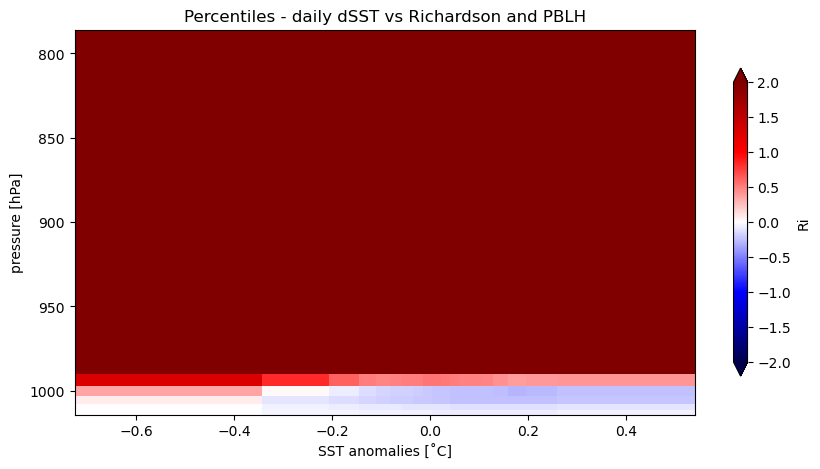

In [35]:
p_level_plot = int(15)

perc = True
x = pdist_dsst #if perc else dist_dsst_day
var = pdist_Ri[0:p_level_plot,:] #if perc else dist_dBV_freq_day[0:p_level_plot,:]*100000
minval = -2. #if perc else -0.05
maxval = -minval
title = 'Percentiles' #if perc else 'Fixed bins'

fig, ax1 = plt.subplots(figsize=(10, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var, vmin=minval, vmax=maxval, cmap='seismic')
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} - daily dSST vs Richardson and PBLH')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('Ri')


'''x_pbl = pdist_dsst #if perc else dist_dsst
var_pbl = pdist_PBLH_dsst #if perc else dist_PBLH_dsst
ax1.plot(x_pbl, var_pbl, 'k')
ax1.text(0.4, 925, 'PBLH', fontsize=12)'''



'''# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_dBV_freq_day_sub[0:p_level_plot] #if perc else pvalue_dBV_freq_day_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')'''


path_img = '/venus/tesi_ale/img_EU/BV/daily/FEB/' if perc else '/venus/tesi_ale/img_EU/BV/daily/FEB/'
filename = path_img + 'pdist_dsst_dBV_lowtropo.png' if perc else path_img + 'bins_dsst_dBV_lowtropo.png'
#plt.savefig(filename)
print(filename)
del filename

In [ ]:
### RICHARDSON VS dSST distributions

perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_Ri, pstd_Ri, pstderr_Ri, pnpoints_Ri, ppvalue_Ri_sub = \
dist_3d_subsample(dsst_day, Ri_feb, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')